# DS4440 - Practical Neural Networks
## Week 2 : Multi Layer Perceptron (Classification & Regression)

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement

Imagine we work for a **medical insurance company** that wants to better understand its customers to improve its services. To achieve this, the company has compiled a dataset containing key information about its clients. By analyzing features such as age, BMI, and region, we can uncover trends and patterns that can inform decisions about insurance plans, marketing strategies, and risk assessment.

Our goal is to explore various predictive tasks using this dataset to gain deeper insights into the customers. These tasks include:


1. **Classification** : Predict if the individual is a smoker or not
2. **Regression**: Estimating the insurance cost for an individual using other features.

To accomplish these tasks, we will use the **Perceptron algorithm**, one of the simplest and most foundational types of neural networks. Despite its simplicity, the Perceptron introduces essential concepts in machine learning and classification, making it a great starting point for understanding how models learn from data.

### About the Dataset

The dataset includes the following features for each individual:  
- **Age**: The age of the individual.  
- **Sex**: The gender of the individual (male or female).  
- **BMI**: Body Mass Index, a measure of body fat based on height and weight.  
- **Children**: Number of children covered by the insurance plan.  
- **Smoker**: Whether the individual is a smoker (yes or no).  
- **Region**: The individual's region of residence (e.g., northeast, southeast, etc.).  
- **Charges**: The medical insurance cost for the individual.

By the end of this notebook, you will understand how to use the Perceptron algorithm to perform both classification and regression tasks, providing a foundational understanding of machine learning.  

Let's dive in!


## Setup and Load libraries

The below cell is written to ensure the right way of loading the helper file that has all the training and modularized code for the course


In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(parent_dir)

In [2]:
! pip install -r ../../requirements.txt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
import helper as hlp

In this notebook, we'll walk through **both** a classification and regression pipeline using **the same dataset** (Medical Insurance Costs). We'll follow the **six** key sections below(these sections will be present in every notebook moving forward):
1. **Data Gathering**
2. **Feature Understanding & Preprocessing**
3. **Exploratory Data Analysis (EDA)**
4. **Model Building**
5. **Model Validation**
6. **Results and Conclusions**

## Data Gathering

In [4]:
df = pd.read_csv("../../Datasets/medical_insurance.csv")

In [5]:
df.head() # This displays the 5 rows of the dataset by default

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis (EDA)

### Check the size of the dataset

In [6]:
size = df.shape
print(f"The dataset has {size[0]} rows and {size[1]} columns")

The dataset has 2772 rows and 7 columns


### Check if NULL/Empty cells are present in the dataset

It checks every column for null values in the dataset and returns the count of all the null values in each column

In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Check the datatypes of each column in the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


### Explore the statistics of the numerical columns in the dataset
This cell provides a summary of statistics (count, mean, std, min, 25%, 50%, 75%, and max) for numerical columns in a DataFrame.

In [9]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


### Explore the statistics of the categorical columns in the dataset

In [10]:
df.describe(include='object')

,sex,smoker,region
count,2772,2772,2772
unique,2,2,4
top,male,no,southeast
freq,1406,2208,766


### Check if there are duplicates in the dataset

In [11]:
df.duplicated()

print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 1435


### Drop the duplicates

In [12]:
print(f'before: {df.duplicated().sum()}')
df.drop_duplicates(inplace = True, ignore_index = True)
print(f'after: {df.duplicated().sum()}')

before: 1435
after: 0


### Explore the class distribution in all the categorical columns

In [13]:
categorical_columns = ['sex', 'smoker', 'region']

for column in categorical_columns:
    print(f"Class distribution for {column}:")
    print(df[column].value_counts())
    print()

Class distribution for sex:
sex
male      675
female    662
Name: count, dtype: int64

Class distribution for smoker:
smoker
no     1063
yes     274
Name: count, dtype: int64

Class distribution for region:
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64



### Understand the dataset through visualizations

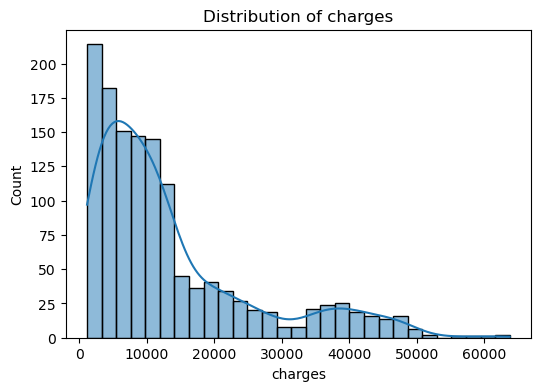

In [14]:
# distribution of charges after scaling numeric cols (though 'charges' itself wasn't scaled)
plt.figure(figsize=(6,4))
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of charges')
plt.show()

The following observations are noted below :
1. The distribution is right-skewed (positive skew), meaning most data points are concentrated at lower charge values, while a smaller number of data points represent much higher charges.
2. The spread of the data shows variability in charges, with most values falling below 20,000 and a few outliers extending up to 60,000.

In [15]:
# distribution of charges after scaling numeric cols (though 'charges' itself wasn't scaled)
numeric_cols = ['age','bmi','children']
bins = [0, 30, 60, 100]
labels = ['low', 'med', 'high']
df["age_bucket"] = pd.cut(df["age"], bins=bins, labels=labels)


In [16]:
df.head()

,age,sex,bmi,children,smoker,region,charges,age_bucket
0,19,female,27.900,0,yes,southwest,16884.92400,low
1,18,male,33.770,1,no,southeast,1725.55230,low
2,28,male,33.000,3,no,southeast,4449.46200,low
3,33,male,22.705,0,no,northwest,21984.47061,med
4,32,male,28.880,0,no,northwest,3866.85520,med


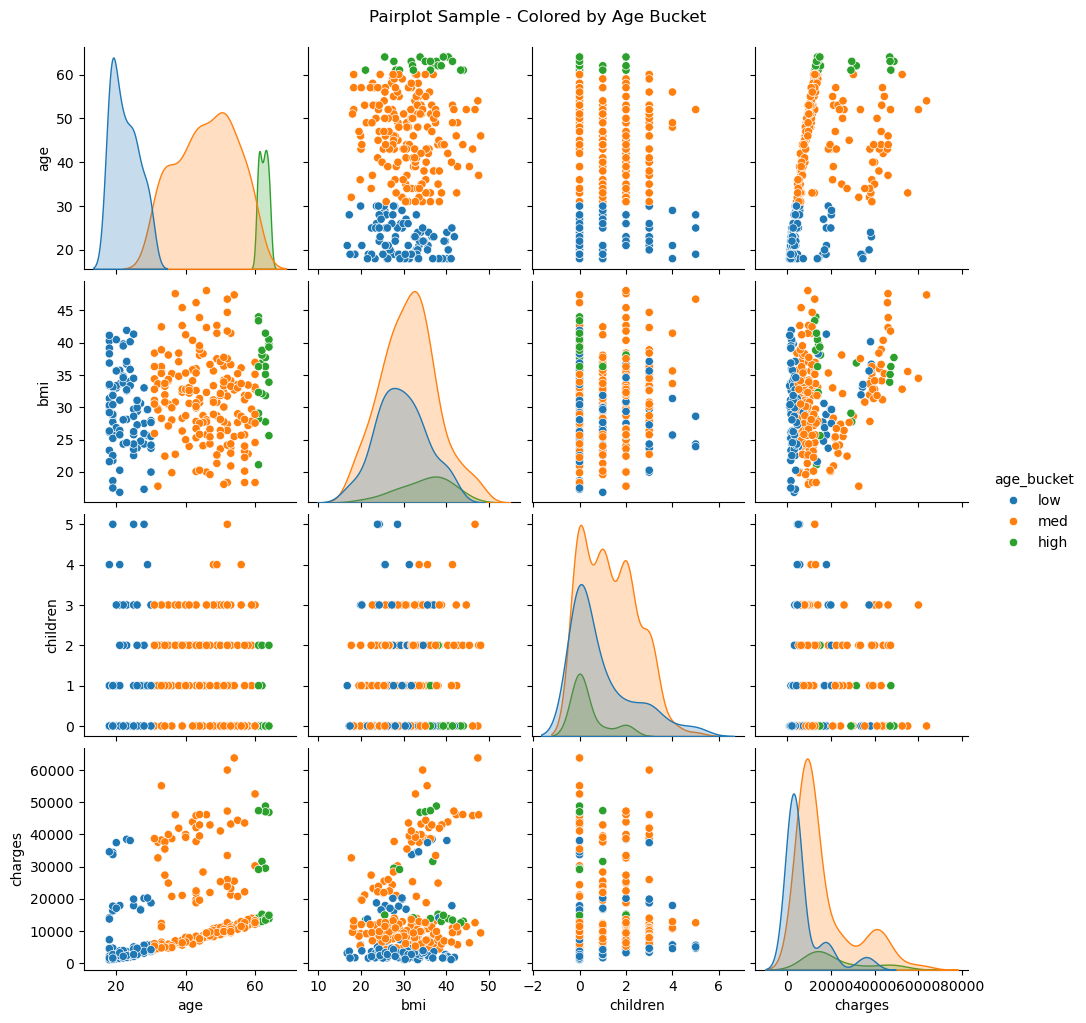

In [17]:
# pairplot to see relationships
sample_df = df[['age','bmi','children','charges','age_bucket']].sample(300, random_state=42)
sns.pairplot(sample_df, hue='age_bucket')
plt.suptitle('Pairplot Sample - Colored by Age Bucket', y=1.02)
plt.show()

From the above visulaizations, we can see the following :
1. As the age increases, the cost of the insurance increases.
2. If your BMI is in the healthy range, you pay lesser insurance fee.
3. Number of children have little to no effect on medical insurance charges.
4. In a real world scenario, very few people have more than 3 children so there are no valuable insights we can gather from the children column

In [18]:
number_column = df.select_dtypes(include=['int64' , 'float64'])
object_column = df.select_dtypes(include='object')

In [19]:
pd.crosstab(df['sex'] , df['smoker'])

smoker,no,yes
sex,,
female,547,115
male,516,159


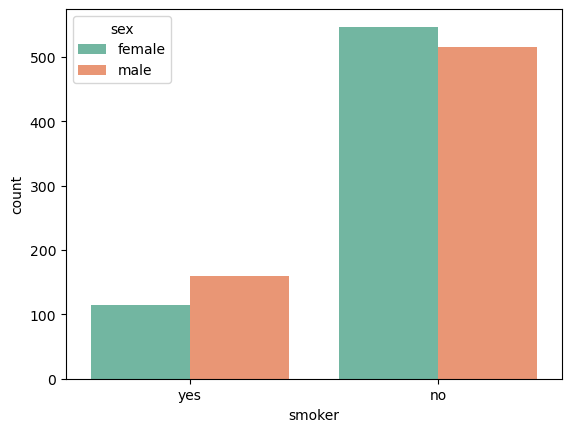

In [20]:
sns.countplot(data =df , x = 'smoker' , hue = 'sex' , palette='Set2')
plt.show()

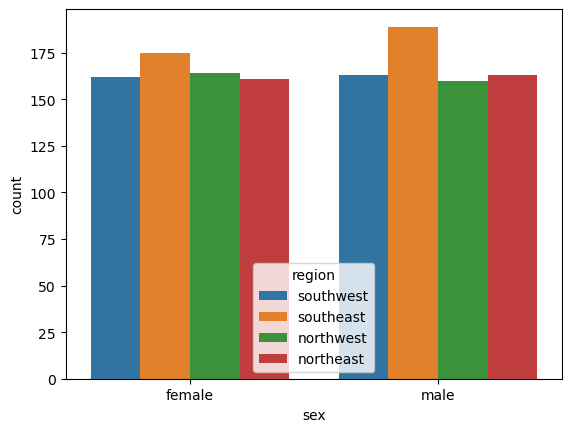

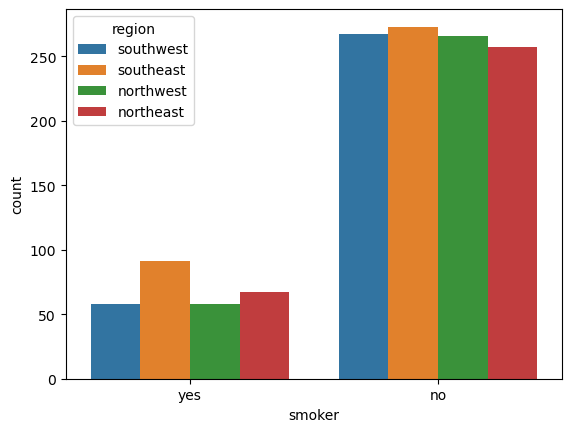

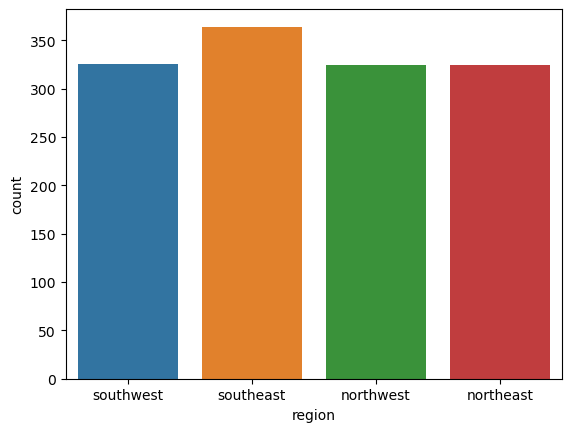

In [21]:
for column in object_column:
    sns.countplot(data = df , x = column  ,hue = 'region')
    plt.show()

## Feature Understanding & Preprocessing

#### Data Preparation for the Model

Before feeding the data into the model, it is essential to perform some preprocessing steps to ensure the data is in a suitable format for training. These steps are crucial for the Perceptron algorithm to converge effectively and provide meaningful results. The key preprocessing steps include:

#### 1. Normalization of Numerical Columns
Normalization is required because:
- **Different scales of features**: The numerical features, such as `age`, `bmi`, and `charges`, may have significantly different ranges. When features are on different scales, the learning algorithm may prioritize certain features over others, leading to biased learning. For example, a large feature like `charges` may dominate the model's learning process if not normalized.
- **Speed of Convergence**: Perceptron and other gradient-based algorithms often perform better when the features are normalized. If one feature dominates due to its scale, the model might converge very slowly or get stuck in a local minimum.
- **Improved Performance**: Normalization ensures that all features contribute equally to the model’s learning process, allowing the algorithm to work more efficiently.

#### 2. One-Hot Encoding of Categorical Columns
One-hot encoding is required because:
- **Non-numeric data**: Machine learning models, including Perceptron, require numerical input. Categorical columns like `smoker` and `region` cannot be directly used by the model as they are non-numeric. One-hot encoding transforms these categorical variables into a series of binary columns, allowing the model to interpret them correctly.
- **Representation of categories**: One-hot encoding ensures that each category is represented as a separate binary feature, avoiding any ordinal or hierarchical assumptions that might be made by algorithms if the categories were represented as integers. For instance, treating the `smoker` feature as integers (1 for "yes", 0 for "no") may suggest an ordering (e.g., "yes" > "no"), which is incorrect in this context.
  
#### 3. Handling Missing or Erroneous Data
Handling missing or erroneous data is required because:
- **Ensuring completeness**: Most machine learning algorithms, including Perceptron, cannot handle missing values. If the dataset has missing values, the model may fail to train or produce unreliable predictions. It is crucial to impute or remove missing data to ensure that the model can process the data correctly.
- **Avoiding bias**: If missing data is ignored or handled improperly, it can introduce bias into the model, making the predictions inaccurate. For instance, simply removing rows with missing values may lead to biased results if the missing data is not missing at random.
  


#### Define the Feature and Target variables

In [22]:
def label_encode_smoker_col(smoker_value):
    if smoker_value == 'yes':
        return 1 
    return 0

In [23]:
X = df[['age', 'bmi', 'children', 'smoker', 'sex', 'region', 'charges']] # Feature set
X['smoker'] = X['smoker'].apply(label_encode_smoker_col)
y = X.pop('smoker') # Target Variable

/var/folders/31/vhwm53rj4tnfvv9lgq9m3x5w0000gn/T/ipykernel_82602/833510960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['smoker'] = X['smoker'].apply(label_encode_smoker_col)


In [24]:
X.head()

,age,bmi,children,sex,region,charges
0,19,27.900,0,female,southwest,16884.92400
1,18,33.770,1,male,southeast,1725.55230
2,28,33.000,3,male,southeast,4449.46200
3,33,22.705,0,male,northwest,21984.47061
4,32,28.880,0,male,northwest,3866.85520


In [25]:
y

0       1
1       0
2       0
3       0
4       0
       ..
1332    0
1333    0
1334    0
1335    0
1336    1
Name: smoker, Length: 1337, dtype: int64

In [26]:
number_column = X.select_dtypes(include=['int64' , 'float64'])
object_column = X.select_dtypes(include='object')

In [27]:
numerical_features = list(number_column.columns) # We defined all numerical columns as number_column above in the notebook
numerical_transformer = StandardScaler()

# Categorical columns to one-hot encode
categorical_features = X.select_dtypes(include='object').columns  # We defined all categorical columns as object_column above in the notebook
categorical_transformer = OneHotEncoder(drop='first') # Adds new columns to the dataset

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform the entire dataset (excluding the target column, assuming it's 'sex')
X_transformed = preprocessor.fit_transform(X)

# Extract feature names for the transformed DataFrame
numerical_names = numerical_features
categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(numerical_names) + list(categorical_names)

df_X_transformed = pd.DataFrame(X_transformed, columns= feature_names)



In [28]:
df_X_transformed.head(10) # Dataset ready to be fed to the model.

,age,bmi,children,charges,sex_male,region_northwest,region_southeast,region_southwest
0,-1.440418,-0.453160,-0.909234,0.297857,0.0,0.0,0.0,1.0
1,-1.511647,0.509422,-0.079442,-0.954381,1.0,0.0,1.0,0.0
2,-0.799350,0.383155,1.580143,-0.729373,1.0,0.0,1.0,0.0
3,-0.443201,-1.305052,-0.909234,0.719104,1.0,1.0,0.0,0.0
4,-0.514431,-0.292456,-0.909234,-0.777499,1.0,1.0,0.0,0.0
5,-0.585661,-0.807363,-0.909234,-0.786604,0.0,0.0,1.0,0.0
6,0.482785,0.455307,-0.079442,-0.416207,0.0,0.0,1.0,0.0
7,-0.158282,-0.479397,1.580143,-0.495432,0.0,1.0,0.0,0.0
8,-0.158282,-0.136672,0.750351,-0.567719,1.0,0.0,0.0,0.0
9,1.480002,-0.790965,-0.909234,1.292271,0.0,1.0,0.0,0.0


## Why MLPs Are Used Instead of Perceptrons

The **Perceptron** can only model **linear decision boundaries** and fails for non-linearly separable data, such as the **XOR problem**. This limitation arises because a perceptron lacks the capacity to learn complex/Non-linear patterns.  

### Why Choose MLPs?
- **Non-Linear Problems**: MLPs solve non-linear problems using hidden layers and activation functions.
- **Complex Patterns**: They model intricate relationships by stacking layers.
- **Versatility**: Useful for tasks like classification, regression, and feature extraction.

---

## Introduction to Multi-Layer Perceptrons (MLPs)

An **MLP** is a network of:
1. **Input Layer**: Accepts features.
2. **Hidden Layers**: Learns complex patterns using weights, biases, and activation functions (e.g., ReLU, sigmoid).
3. **Output Layer**: Provides predictions.

MLPs extend the perceptron by introducing **non-linear activations** and **multiple layers**, enabling them to approximate any continuous function and solve diverse machine learning tasks.

![Perceptron Diagram](mlp.gif)


**Note**: To understand how perceptrons work, refer to this: [Go to Target Section](../../Perceptron/Class01_Perceptron/DS4440_Perceptron.ipynb#introduction-to-perceptrons)




## **Classification**

In this task, our goal is to predict if an individual is a smoker or not.

### **Features Used for Prediction**
We will utilize the following features to make predictions about the individual:

1. **Age**: The age of the individual.
2. **BMI**: Body Mass Index, a measure of body fat based on height and weight.
3. **Children**: The number of children/dependents the individual has.
4. **Gender**: Whether the individual is a male or female.
5. **Region**: The region of residence (e.g., northeast, northwest, southeast, southwest).


### **Objective**
The objective is to build a classification model that can accurately predict if an individual is a smoker or not.




#### Model Building Using PyTorch

In [29]:
# The Features that will be passed to the model.
X_transformed

array([[-1.44041773, -0.45315959, -0.90923416, ...,  0.        ,
         0.        ,  1.        ],
       [-1.51164747,  0.50942165, -0.07944162, ...,  0.        ,
         1.        ,  0.        ],
       [-0.79935006,  0.3831546 ,  1.58014347, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.51164747,  1.01448983, -0.90923416, ...,  0.        ,
         1.        ,  0.        ],
       [-1.29795825, -0.79752426, -0.90923416, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.55123139, -0.26129928, -0.90923416, ...,  1.        ,
         0.        ,  0.        ]])

In [30]:
# The Target Variable
y = np.array(y)
y

array([1, 0, 0, ..., 0, 0, 1])

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [32]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make it 2D for PyTorch
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [33]:
X_train

tensor([[-1.1555, -1.0091, -0.9092,  ...,  0.0000,  0.0000,  0.0000],
        [-1.2980, -0.8065,  0.7504,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9102,  1.1252,  0.7504,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [-1.3692, -1.4207, -0.0794,  ...,  0.0000,  0.0000,  1.0000],
        [-0.0871, -0.4368,  1.5801,  ...,  0.0000,  0.0000,  1.0000],
        [-0.3007,  0.8521,  0.7504,  ...,  0.0000,  1.0000,  0.0000]])

In [34]:
y_train

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [35]:
class MLP_CLassification(nn.Module):
    def __init__(self, input_size):
        super(MLP_CLassification, self).__init__()
        self.fc = nn.Linear(input_size, 64)          # First fully connected layer
        self.hidden_layer = nn.Linear(64, 32)       # Hidden layer
        self.output_layer = nn.Linear(32, 1)        # Output layer
        self.relu = nn.ReLU()                       # ReLU activation

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)                            # Apply ReLU after the first layer
        x = self.hidden_layer(x)
        x = self.relu(x)                            # Apply ReLU after the hidden layer
        x = self.output_layer(x)
        x = torch.sigmoid(x)                        # Sigmoid activation for binary classification
        return x

# Initialize the model
input_size = X_train.shape[1]  # The number of columns in your X feature set
print(input_size)
model = MLP_CLassification(input_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 100


# Training loop
hlp.classification_train_model(model,X_train, y_train, X_test, y_test, epochs, criterion, optimizer)

8
-------------------Epoch 1/100--------------------
  Weights: tensor([[-0.3113, -0.2765, -0.1544, -0.0617,  0.0101,  0.2250,  0.0575, -0.0688],
        [-0.0827,  0.2090, -0.0513, -0.1023, -0.3018,  0.2152, -0.0446, -0.0581],
        [ 0.1901,  0.2217,  0.0766, -0.1411,  0.1228,  0.1350,  0.2055, -0.1640],
        [-0.0545,  0.2166,  0.2539,  0.3318, -0.0665, -0.3383,  0.2279,  0.2386],
        [ 0.3052,  0.1254,  0.3023, -0.0151,  0.2557,  0.0391,  0.0675, -0.1395],
        [ 0.2443,  0.0527, -0.3317, -0.2929,  0.2850, -0.1794, -0.2360,  0.0203],
        [-0.1546,  0.0030, -0.3424, -0.3117, -0.2456, -0.2427,  0.3263,  0.2226],
        [ 0.1250, -0.0079,  0.0023,  0.2465,  0.1490,  0.0191,  0.0721,  0.2861],
        [ 0.3251,  0.0628, -0.0949,  0.1370, -0.2464,  0.1801,  0.3020, -0.0593],
        [-0.2663, -0.0571,  0.0431, -0.0578, -0.1379, -0.1737, -0.3216, -0.0955],
        [ 0.2108,  0.1403,  0.1452, -0.2217,  0.3137, -0.0524,  0.1435, -0.0224],
        [-0.0757,  0.0856,  0.3107

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_

In [36]:
# Evaluation
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred > 0.5).float()  # Thresholding at 0.5
    accuracy = accuracy_score(y_test, y_pred_class)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_class))

Accuracy: 0.7761
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.87       208
         1.0       0.00      0.00      0.00        60

    accuracy                           0.78       268
   macro avg       0.39      0.50      0.44       268
weighted avg       0.60      0.78      0.68       268



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Regression**

In this task, our goal is to predict the insurance charge as a continuous numerical variable.

### **Features Used for Prediction**
We will utilize the following features to make predictions about gender:

1. **Age**: The age of the individual.
2. **BMI**: Body Mass Index, a measure of body fat based on height and weight.
3. **Children**: The number of children/dependents the individual has.
4. **Smoker**: Whether the individual is a smoker or not (Yes/No).
5. **Region**: The region of residence (e.g., northeast, northwest, southeast, southwest).



### **Objective**
The objective is to build a regression model that can accurately predict the insurance charge as a continuos numerical variable.




#### Model Building Using PyTorch

In [37]:
# The Features that will be passed to the model.
X = df[['age', 'bmi', 'children', 'smoker', 'region', 'charges','sex']] # Feature set
X["charges"] = X["charges"].apply(lambda x: round(x,2))
y = X.pop('charges') # Target Variable
number_column = X.select_dtypes(include=['int64' , 'float64'])
object_column = X.select_dtypes(include='object')
numerical_features = list(number_column.columns) # We defined all numerical columns as number_column above in the notebook
numerical_transformer = StandardScaler()

# Categorical columns to one-hot encode
categorical_features = X.select_dtypes(include='object').columns  # We defined all categorical columns as object_column above in the notebook
categorical_transformer = OneHotEncoder(drop='first') # Adds new columns to the dataset

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform the entire dataset (excluding the target column, assuming it's 'sex')
X_transformed = preprocessor.fit_transform(X)

# Extract feature names for the transformed DataFrame
numerical_names = numerical_features
categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(numerical_names) + list(categorical_names)

df_X_transformed = pd.DataFrame(X_transformed, columns= feature_names)



/var/folders/31/vhwm53rj4tnfvv9lgq9m3x5w0000gn/T/ipykernel_82602/4235774638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["charges"] = X["charges"].apply(lambda x: round(x,2))


In [38]:
# The Target Variable
y = np.array(y)
y

array([16884.92,  1725.55,  4449.46, ...,  1629.83,  2007.94, 29141.36])

In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [40]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make it 2D for PyTorch
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [41]:
X_train

tensor([[-1.1555, -1.0091, -0.9092,  ...,  0.0000,  0.0000,  1.0000],
        [-1.2980, -0.8065,  0.7504,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.9102,  1.1252,  0.7504,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.3692, -1.4207, -0.0794,  ...,  0.0000,  1.0000,  1.0000],
        [-0.0871, -0.4368,  1.5801,  ...,  0.0000,  1.0000,  0.0000],
        [-0.3007,  0.8521,  0.7504,  ...,  1.0000,  0.0000,  0.0000]])

In [42]:
y_train

tensor([[ 2396.1001],
        [ 3279.8701],
        [33471.9688],
        ...,
        [ 1964.7800],
        [ 7151.0898],
        [ 5836.5200]])

In [43]:
X_train.shape

torch.Size([1069, 8])

In [44]:
# Define Perceptron for Regression
class MLP_Regression(nn.Module):
    def __init__(self, input_size):
        super(MLP_Regression, self).__init__()
        self.fc = nn.Linear(input_size, 64)          # First fully connected layer
        self.hidden_layer = nn.Linear(64, 32)       # Hidden layer
        self.output_layer = nn.Linear(32, 1)        # Output layer
        self.relu = nn.ReLU()                       # ReLU activation

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)                            # Apply ReLU after the first layer
        x = self.hidden_layer(x)
        x = self.relu(x)                            # Apply ReLU after the hidden layer
        x = self.output_layer(x)
        return x

# Initialize the model
input_size = X_train.shape[1]  # The number of columns in your feature set
model = MLP_Regression(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Corrected optimizer

# Training loop
epochs = 100
hlp.regression_train_model(model, X_train, y_train, X_test, y_test, epochs=epochs, criterion=criterion, optimizer=optimizer)

-------------------Epoch 1/100--------------------
  Weights: tensor([[-2.5610e-01, -2.9195e-01, -5.2413e-03, -2.6272e-01,  2.9610e-01,
         -1.4035e-01, -3.1347e-01,  2.7140e-01],
        [-2.5423e-01,  2.6798e-01, -2.7083e-01, -2.6053e-01,  1.2778e-01,
          2.7538e-01,  1.9187e-01, -1.1775e-01],
        [-2.6365e-01, -7.8586e-02,  1.2858e-02, -2.8764e-01,  8.7111e-02,
          2.1570e-01, -1.5234e-02, -2.1509e-01],
        [-3.4143e-01,  2.1332e-01,  3.1699e-01,  2.5483e-01, -2.9892e-01,
         -3.1759e-01, -1.2419e-01, -1.3170e-01],
        [ 2.2600e-01,  3.0103e-01, -3.1757e-01,  4.6507e-02, -5.6495e-02,
         -1.4352e-01, -3.1418e-01, -6.2946e-03],
        [-1.2320e-01,  1.7438e-01,  2.6492e-02,  8.7317e-02,  3.2581e-01,
         -6.7388e-02, -8.8323e-02, -3.4743e-01],
        [-3.0395e-01,  8.4769e-02, -2.0852e-01, -1.6983e-01, -7.5657e-02,
          3.0120e-01, -2.5104e-01, -2.4118e-01],
        [ 3.4157e-01, -2.2991e-01, -1.2725e-01,  2.5257e-01,  3.2989e-01,
   

In [45]:
with torch.no_grad():
    y_pred = model(X_test)  # Get predictions

    y_pred = y_pred.numpy()  # Convert to numpy array for evaluation

    y_test = y_test.numpy()  # Convert ground truth to numpy array

    # Calculate regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 386790368.0000
Mean Absolute Error (MAE): 14252.5273
R-squared (R²): -1.1049
